<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_IA/blob/main/08_deep_learning/tp_01_v04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
#import tensorflow.keras.optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import keras as keras
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.callbacks import ModelCheckpoint
import seaborn as sns
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn import metrics

In [ ]:
#!pip install tensorflow

In [84]:
## column to predict
y_col = 'TotalScore'

In [85]:
def get_df_from_csv(p_path, p_sep=',', p_print=True):
  df= pd.read_csv(p_path, sep= p_sep)
  if (p_print):
    print('---Head---')
    print(df.head())
    print('-- How many nulls? --')
    print(df.isna().sum())
  return df


In [86]:
## Augmented df
def get_augmented_df():
  ## head 400001
  path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/AugmentedData_reduced.csv"
  augmented_df_1 = get_df_from_csv(path_csv, p_sep =",")
  ## tail 284000
  path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/AugemntedData_reduced_tail.csv"
  augmented_df_2 = get_df_from_csv(path_csv, p_sep =",")

  return pd.concat([augmented_df_1, augmented_df_2])

In [87]:
## augmented_df (full augmented_df)
augmented_df = get_augmented_df()

---Head---
   GameID  ScenarioID  HolesCompletedCount  Hole1  Hole2  Hole3  Hole4  Hole5  \
0       1           1                    0      0      0      0      0      0   
1       2           1                    0      0      0      0      0      0   
2       3           1                    0      0      0      0      0      0   
3       4           1                    0      0      0      0      0      0   
4       5           1                    0      0      0      0      0      0   

   Hole6  Hole7  ...  Hole10  Hole11  Hole12  Hole13  Hole14  Hole15  Hole16  \
0      0      0  ...       0       0       0       0       0       0       0   
1      0      0  ...       0       0       0       0       0       0       0   
2      0      0  ...       0       0       0       0       0       0       0   
3      0      0  ...       0       0       0       0       0       0       0   
4      0      0  ...       0       0       0       0       0       0       0   

   Hole17  Hole18  To

In [88]:
## nulls?
print(augmented_df.isnull().sum())
print(augmented_df[y_col].mode())


GameID                 283999
ScenarioID             283999
HolesCompletedCount    283999
Hole1                  283999
Hole2                  283999
Hole3                  283999
Hole4                  283999
Hole5                  283999
Hole6                  283999
Hole7                  283999
Hole8                  283999
Hole9                  283999
Hole10                 283999
Hole11                 283999
Hole12                 283999
Hole13                 283999
Hole14                 283999
Hole15                 283999
Hole16                 283999
Hole17                 283999
Hole18                 283999
TotalScore             283999
1                      400000
201                    400000
10                     400000
4                      400000
6                      400000
0                      400000
0.1                    400000
0.2                    400000
0.3                    400000
0.4                    400000
0.5                    400000
0.6       

In [89]:
### several nulls...
### Let's create a function to replace nulls with most frequent values

def get_df_without_nulls(p_df):
  for col in p_df.columns:
    most_frequent_value = p_df[col].mode()[0]
    p_df[col].fillna(most_frequent_value, inplace=True)
  return p_df


In [90]:
#### still any nulls?
augmented_df2 = get_df_without_nulls(augmented_df)

print(augmented_df2.isnull().sum())
print(augmented_df2[y_col].mode())

GameID                 0
ScenarioID             0
HolesCompletedCount    0
Hole1                  0
Hole2                  0
Hole3                  0
Hole4                  0
Hole5                  0
Hole6                  0
Hole7                  0
Hole8                  0
Hole9                  0
Hole10                 0
Hole11                 0
Hole12                 0
Hole13                 0
Hole14                 0
Hole15                 0
Hole16                 0
Hole17                 0
Hole18                 0
TotalScore             0
1                      0
201                    0
10                     0
4                      0
6                      0
0                      0
0.1                    0
0.2                    0
0.3                    0
0.4                    0
0.5                    0
0.6                    0
0.7                    0
5                      0
4.1                    0
4.2                    0
6.1                    0
4.3                    0


In [91]:
## Original df
path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/OriginalData.csv"
original_df = get_df_from_csv(path_csv, p_sep =",")

---Head---
   GameID  Hole1  Hole2  Hole3  Hole4  Hole5  Hole6  Hole7  Hole8  Hole9  \
0       1      4      6      5      4      6      5      5      3      5   
1       2      3      5      4      4      5      5      6      3      4   
2       3      5      4      6      4      7      4      5      3      5   
3       4      4      4      7      3      6      4      4      4      5   
4       5      4      7      6      4      5      4      5      3      4   

   Hole10  Hole11  Hole12  Hole13  Hole14  Hole15  Hole16  Hole17  Hole18  \
0       4       5       4       4       6       4       5       4       6   
1       5       5       5       4       5       3       4       3       4   
2       6       6       5       4       5       3       5       3       3   
3       7       5       7       4       6       3       6       3       4   
4       6       9       6       3       5       4       5       3       4   

   TotalScore  
0          85  
1          77  
2          83  
3    

In [92]:
## nulls?
original_df.isna().sum()

GameID        0
Hole1         0
Hole2         0
Hole3         0
Hole4         0
Hole5         0
Hole6         0
Hole7         0
Hole8         0
Hole9         0
Hole10        0
Hole11        0
Hole12        0
Hole13        0
Hole14        0
Hole15        0
Hole16        0
Hole17        0
Hole18        0
TotalScore    0
dtype: int64

In [37]:
## most frequent value?
print(original_df[y_col].mode())
print(original_df[y_col].mean())

0    83
Name: TotalScore, dtype: int64
83.0655


In [ ]:
## naïve prediction (baseline) can be original_df[y_col].mode(), original_df[y_col].mean()

In [93]:
## train test split
## we apply the scaler
def get_train_test(pDf=original_df, p_var_y=y_col, p_test_size=0.2, p_random_state=25):
  dfX = pDf.drop(p_var_y, axis=1).values
  dfY = pDf[p_var_y]

  # Apply standardization to feature values
  scaler = StandardScaler()
  dfX_standardized = scaler.fit_transform(dfX)

  X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=p_test_size, random_state=p_random_state)
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=p_test_size, random_state=p_random_state)

  return X_train, X_valid, X_test, y_train, y_valid, y_test


########## Establishing a baseline #########

In [127]:
def analyze_dummy(p_df, p_X_train, p_X_valid, p_y_train ,p_y_valid):
  baseline_reg = DummyRegressor()
  baseline_reg.fit(p_X_train, p_y_train)
  print("[score train]", baseline_reg.score(p_X_train, p_y_train))
  print("[score valid]", baseline_reg.score(p_X_valid, p_y_valid))

  y_pred = baseline_reg.predict(p_y_valid)

  print('Root Mean Squared Error - [RMSE]:', round(np.sqrt(metrics.mean_squared_error(p_y_valid, y_pred)),3) )
  print('Mean Squared Error - [MSE]:', round(metrics.mean_squared_error(p_y_valid, y_pred),3) )



In [128]:
## augmented_df
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_test(augmented_df2)
analyze_dummy(augmented_df2, X_train, X_valid, y_train, y_valid)

[score train] 0.0
[score valid] -2.5220723929519906e-05
Root Mean Squared Error - [RMSE]: 5.351
Mean Squared Error - [MSE]: 28.635


In [96]:
## original df
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_test(original_df)
analyze_dummy(original_df, X_train, X_valid, y_train, y_valid)

[score train] 0.0
[score valid] -0.000796875625000304
Root Mean Squared Error - [RMSE]: 7.06
Mean Squared Error - [MSE]: 49.844


#############################

Our model must perform better than

Root Mean Squared Error - [RMSE]: 5.351

#############################


####### Simple regression ######


In [157]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score

In [151]:
### affiche les metriques
def print_metrics(pY, pYpred, nbDecimal=3 ):
    #print('Mean Absolute Error - [MAE]:', round(metrics.mean_absolute_error(pY, pYpred), nbDecimal) )
    print('Mean Squared Error - [MSE]:', round(metrics.mean_squared_error(pY, pYpred),nbDecimal ) )
    #print('Score - [accuracy]: ', round(pRegressor.score(pY, pYpred), nbDecimal))
    print('Root Mean Squared Error - [RMSE]:', round(np.sqrt(metrics.mean_squared_error(pY, pYpred)),nbDecimal) )
    #print('[Classification report]')
    #print(classification_report(pYtest, pYpred, labels = donnee['ozone'].unique()))


In [177]:
from sklearn.model_selection import LeaveOneOut
def analyze_regression(p_X_train,
                       p_X_test,
                       p_y_train,
                       p_y_test,
                       pCv=4,
                       pMaxIter=1000
                       ):



    print("-----[Linear Regression]-----")
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(p_X_train, p_y_train)

    loo = LeaveOneOut()
    #print(loo.get_n_splits(X))
    #crossvalidation = KFold(n_splits=392, random_state=None, shuffle=False)

    ##http://www.science.smith.edu/~jcrouser/SDS293/labs/lab7-py.html
    scores_train = cross_val_score(regr, p_X_train, p_y_train, cv=loo, scoring="neg_mean_squared_error")
    mse_train = np.mean(np.abs(scores_train))
    print("---[train]---")
    #print("[train] -   MSE: " + str(mse_train) + ", STD: " + str(np.std(scores_train)))
    print("RMSE ", round(np.sqrt(mse_train),3) )
    print("MSE ", round(mse_train,3))
    #print("score ", round(np.std(scores_train),3) )


    scores_test = cross_val_score(regr, p_X_test, p_y_test, cv=loo, scoring="neg_mean_squared_error")
    mse_test = np.mean(np.abs(scores_test))
    print("---[test]---")
    #print("[test] -   MSE: " + str(mse_test) + ", STD: " + str(np.std(scores_test)))
    print("RMSE ", round(np.sqrt(mse_test),5 ))
    print("MSE ", round(mse_test,5))
    #print("score ", round(np.std(scores_test),3) )



In [178]:
## regression
analyze_regression(p_X_train = X_train,
                       p_X_test = X_valid,
                       p_y_train = y_train,
                       p_y_test = y_valid)

-----[Linear Regression]-----
---[train]---
RMSE  0.0
MSE  0.0
---[test]---
RMSE  0.0
MSE  0.0


In [179]:
### elasticnet, ridge, lasso
def analyze_regularization(
                    pAlphas
                    , pRegressorName
                    , pRegressorCVName
                    , p_X_train
                    , p_X_test
                    , p_y_train
                    , p_y_test
                    , pCv=5
                    , pMaxIter=1000
                    ):



    print("----["+pRegressorName+"]----")
    regr = globals()[pRegressorCVName](alphas=pAlphas, cv=pCv).fit(p_X_train, p_y_train)
    #regr = linear_model.ElasticNetCV(alphas=pAlphas, cv=pCv).fit(X_train, y_train)

    print("[alpha]: ", regr.alpha_)

    modele_final = globals()[pRegressorName](regr.alpha_, max_iter=pMaxIter).fit(p_X_train, p_y_train)

    y_pred_train = regr.predict(p_X_train)
    y_pred_test = regr.predict(p_X_test)


    print("---[train]---")
    print_metrics(p_y_train, y_pred_train)

    print("---[test]---")
    #print("[score]: ",  regr.score(X_test, y_test))
    print_metrics(p_y_test, y_pred_test)

In [155]:
type(original_df)

pandas.core.frame.DataFrame

In [181]:
### Ridge avec var exponnentielles
lstAlpha = [0.5, 0.8, 1, 1.2, 1.3]
#analyze_ridge(powerDfX, dfY, lstAlpha)
#lstAlpha = [  7, 8, 8.4, 8.5, 8.6,  10, 10.5]
analyze_regularization( lstAlpha
                       , pRegressorName = "Ridge"
                       , pRegressorCVName = "RidgeCV"
                       , p_X_train = X_train
                       , p_X_test = X_valid
                       , p_y_train = y_train
                       , p_y_test = y_valid
                      )

----[Ridge]----
[alpha]:  0.5
---[train]---
Mean Squared Error - [MSE]: 0.0
Root Mean Squared Error - [RMSE]: 0.001
---[test]---
Mean Squared Error - [MSE]: 0.0
Root Mean Squared Error - [RMSE]: 0.001


###################


In [115]:
## create model
def create_model (p_learning_rate, p_dropout_rate, pDfX, p_nb_neuron_input=128, p_activation='relu'):
  model = Sequential()
  model.add(Dense(p_nb_neuron_input, input_dim=pDfX.shape[1], activation=p_activation))
  model.add(Dropout(p_dropout_rate))
  model.add(Dense(int(p_nb_neuron_input/2), activation=p_activation))
  model.add(Dropout(p_dropout_rate))
  model.add(Dense(int(p_nb_neuron_input/4), activation=p_activation))
  model.add(Dropout(p_dropout_rate))
  model.add(Dense(1))

  adam = Adam(lr = p_learning_rate)

  #model.compile( loss='mean_squared_error', optimizer=adam, metrics=['mae'])
  model.compile( loss='mean_squared_error', optimizer=adam, metrics=['mse'])
  return model


In [129]:
## build model (book HandsOn -on ML, Aurélien Géron)
def build_model (p_input_shape,
                 p_n_hidden=1,
                 p_n_neurons=30,
                 p_learning_rate=3e-3,
                 p_activation='relu'):
  model = Sequential()
  model.add(keras.layers.InputLayer(input_shape=p_input_shape))
  for layer in range(p_n_hidden):
    model.add(keras.layers.Dense(p_n_neurons, activation=p_activation))
    model.add(keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5))
    #keras.layers.BatchNormalization()
  model.add(keras.layers.Dense(1))
  optimizer = keras.optimizers.SGD(lr=p_learning_rate)

  #arr_metrics = ['mae', 'accuracy']
  #arr_metrics = ['mae']
  arr_metrics = ['mse']

  model.compile(loss='mse', optimizer = optimizer, metrics=arr_metrics)
  return model

In [98]:
## augmented_df
## getting train, test sets
X_train, X_valid, X_test, y_train, y_valid,  y_test = get_train_test(augmented_df2)

In [130]:
## original_df
## getting train, test sets
X_train, X_valid, X_test, y_train, y_valid,  y_test = get_train_test(original_df)

In [131]:
print(np.sum(np.isnan(X_train)))
print(np.sum(np.isnan(X_valid)))
print(np.sum(np.isnan(X_test)))
print(np.sum(np.isnan(y_train)))
print(np.sum(np.isnan(y_valid)))
print(np.sum(np.isnan(y_test)))

0
0
0
0
0
0


In [132]:
model = create_model (0.001, 0.3, X_train)

In [73]:
def plot_graph(p_model_history):
    # Plot MAE
    plt.plot(p_model_history['mae'])
    plt.plot(p_model_history['val_mae'])

    # Plot loss
    plt.plot(p_model_history['loss'])
    plt.plot(p_model_history['val_loss'])

    # Add labels and legends for MAE and loss
    plt.legend(['train MAE', 'test MAE', 'train loss', 'test loss'], loc='upper right')
    plt.title('Model Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.show()

    # Plot accuracy (if applicable)
    if 'accuracy' in p_model_history:
        plt.plot(p_model_history['accuracy'])
        plt.plot(p_model_history['val_accuracy'])

        # Add labels and legends for accuracy
        plt.legend(['train accuracy', 'test accuracy'], loc='upper right')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.show()


In [107]:
def plot_graph_2(p_model_history, p_var_valid, p_var_test, p_arr_legend):
    # Plot MAE
    plt.plot(p_model_history[p_var_valid])
    plt.plot(p_model_history[p_var_test])

    ## Plot loss
    #plt.plot(p_model_history['loss'])
    #plt.plot(p_model_history['val_loss'])

    ## Add labels and legends for MAE and loss
    #plt.legend(['train MAE', 'test MAE', 'train loss', 'test loss'], loc='upper right')
    plt.legend(p_arr_legend, loc='upper right')
    plt.title('Model Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.show()






In [134]:
def do_analysis(pModel, pXTrain, pYTrain, pXTest, pYTest,
                p_dropout_rate =0.3, p_learning_rate=0.01, p_epochs =30, p_batch_size=10,
                p_validation_split=0.2, p_verbose=True, p_plot_graph=1):

  ## we fit with train
  model_history = pModel.fit(pXTrain, pYTrain, batch_size=p_batch_size, epochs=p_epochs, validation_split = p_validation_split, verbose=1)

  ## we evaluate model's accuracy (use TEST vars, NOT TRAIN)
  score = pModel.evaluate(pXTest, pYTest, verbose=p_verbose)

  print("[Loss]: ", score[0])
  print("[MSE]: ", score[1])

  if(p_plot_graph):
    #plot_graph(model_history.history)
    #plot_graph_2(model_history.history, 'mae', 'val_mae', ['train MAE', 'test MAE'])
    plot_graph_2(model_history.history, 'mse', 'val_mse', ['train MSE', 'test MSE'])
    plot_graph_2(model_history.history, 'loss', 'val_loss', ['train LOSS', 'test LOSS'])


Epoch 1/50
103/103 [==============================] - 1s 4ms/step - loss: 6058.3442 - mse: 6058.3442 - val_loss: 2823.2405 - val_mse: 2823.2405
Epoch 2/50
103/103 [==============================] - 0s 3ms/step - loss: 2838.4521 - mse: 2838.4521 - val_loss: 3082.2031 - val_mse: 3082.2031
Epoch 3/50
103/103 [==============================] - 0s 3ms/step - loss: 1674.1210 - mse: 1674.1210 - val_loss: 988.5646 - val_mse: 988.5646
Epoch 4/50
103/103 [==============================] - 0s 3ms/step - loss: 1164.3824 - mse: 1164.3824 - val_loss: 951.8929 - val_mse: 951.8929
Epoch 5/50
103/103 [==============================] - 0s 3ms/step - loss: 1081.2546 - mse: 1081.2546 - val_loss: 739.3779 - val_mse: 739.3779
Epoch 6/50
103/103 [==============================] - 0s 2ms/step - loss: 975.9260 - mse: 975.9260 - val_loss: 503.5330 - val_mse: 503.5330
Epoch 7/50
103/103 [==============================] - 0s 3ms/step - loss: 928.3513 - mse: 928.3513 - val_loss: 789.5933 - val_mse: 789.5933
Epoch 

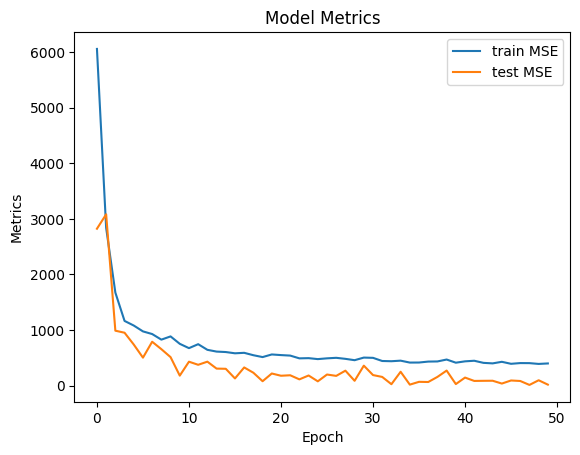

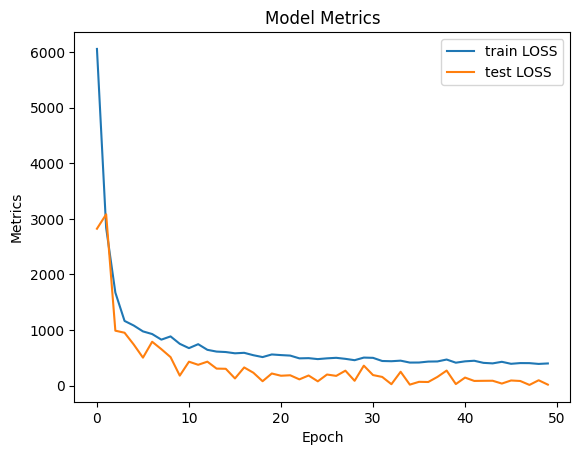

In [138]:
## Modele valuation
model = create_model (0.001, 0.3, X_train)
do_analysis(model, X_train, y_train, X_test, y_test, p_learning_rate =0.0001, p_epochs=50, p_verbose=0)

In [146]:
# Split your data and define input_shape
input_shape = X_train.shape[1]  # Number of features

# Create the KerasRegressor with your build_model function
keras_reg = KerasRegressor(build_fn=build_model, p_input_shape=input_shape, p_n_hidden=3, p_n_neurons=30, p_learning_rate=3e-4, p_activation='relu')


<ipython-input-146-bba7af904efa>:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=build_model, p_input_shape=input_shape, p_n_hidden=3, p_n_neurons=30, p_learning_rate=3e-4, p_activation='relu')


In [147]:
keras_reg.fit( X_train, y_train, epochs = 40,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

msa_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_test)

# Calculate Mean Squared Error (MSE)
print('y_test: ', y_test.isna().sum())
dfYPred = pd.DataFrame(y_pred)
print('y_pred: ', dfYPred.isna().sum())
mse = mean_squared_error(y_test, y_pred)
mse_test = -msa_test

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

print("[MSE] Mean Squared Error:", mse)
print("[MSE] Mean Squared Error:", mse_test)
print("R-squared:", r2)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


40/40 [==============================] - 1s 9ms/step - loss: 6041.4800 - mse: 6041.4800 - val_loss: 4097.6475 - val_mse: 4097.6475
Epoch 2/40
40/40 [==============================] - 0s 4ms/step - loss: 1307.4932 - mse: 1307.4932 - val_loss: 91.2509 - val_mse: 91.2509
Epoch 3/40
40/40 [==============================] - 0s 3ms/step - loss: 54.8493 - mse: 54.8493 - val_loss: 125.1270 - val_mse: 125.1270
Epoch 4/40
40/40 [==============================] - 0s 4ms/step - loss: 50.2228 - mse: 50.2228 - val_loss: 54.0249 - val_mse: 54.0249
Epoch 5/40
40/40 [==============================] - 0s 4ms/step - loss: 49.4882 - mse: 49.4882 - val_loss: 60.7082 - val_mse: 60.7082
Epoch 6/40
40/40 [==============================] - 0s 3ms/step - loss: 49.2522 - mse: 49.2522 - val_loss: 78.8422 - val_mse: 78.8422
Epoch 7/40
40/40 [==============================] - 0s 3ms/step - loss: 48.4606 - mse: 48.4606 - val_loss: 137.2689 - val_mse: 137.2689
Epoch 8/40
40/40 [==============================] - 0s 3m

In [148]:
# Define the checkpoint callback
checkpoint_cb = ModelCheckpoint(filepath="best_model.h5", save_best_only=True)

# Other callbacks you might have (e.g., EarlyStopping)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)

param_distribs = {
    "p_n_hidden": [0,1,2,3],
    "p_n_neurons": np.arange(1,500),
    "p_learning_rate" : reciprocal(1e-5, 1e-2)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=3, scoring='neg_mean_squared_error')

rnd_search_cv.fit(X_train, y_train, epochs=50,
                  validation_data=(X_valid, y_valid),
                  callbacks=[checkpoint_cb, early_stopping_cb])

# Access the best model and print its summary
best_model = rnd_search_cv.best_estimator_.model
print('================================')
print('-- Best Model Summary --')
best_model.summary()
print('-- Best params --')
print(rnd_search_cv.best_params_)
print('-- Best score --')
print(rnd_search_cv.best_score_)



/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
27/27 [==============================] - 1s 15ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/50
27/27 [==============================] - 0s 7ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/50
27/27 [==============================] - 0s 6ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/50
27/27 [==============================] - 0s 8ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/50
27/27 [==============================] - 0s 12ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/50
27/27 [==============================] - 0s 9ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/50
27/27 [==============================] - 0s 14ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/50
27/27 [==============================] - 0

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 102, in _check_reg_targets
    y_pred = check_array(

27/27 [==============================] - 1s 8ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/50
27/27 [==============================] - 0s 4ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 102, in _check_reg_targets
    y_pred = check_array(

27/27 [==============================] - 1s 13ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/50
27/27 [==============================] - 0s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/50
27/27 [==============================] - 0s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/50
27/27 [==============================] - 0s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/50
27/27 [==============================] - 0s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/50
27/27 [==============================] - 0s 4ms/step - 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 102, in _check_reg_targets
    y_pred = check_array(

27/27 [==============================] - 1s 10ms/step - loss: 6847.3135 - mse: 6847.3135 - val_loss: 6773.8555 - val_mse: 6773.8555
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 6728.0166 - mse: 6728.0166 - val_loss: 6700.8306 - val_mse: 6700.8306
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 6588.8364 - mse: 6588.8364 - val_loss: 6585.1162 - val_mse: 6585.1162
Epoch 4/50
27/27 [==============================] - 0s 5ms/step - loss: 6412.5957 - mse: 6412.5957 - val_loss: 6334.8608 - val_mse: 6334.8608
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 6178.9287 - mse: 6178.9287 - val_loss: 5983.9492 - val_mse: 5983.9492
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 5862.3545 - mse: 5862.3545 - val_loss: 5591.6821 - val_mse: 5591.6821
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 5436.6025 - mse: 5436.6025 - val_loss: 1450.1942 - val_mse: 1450.1942
Epoch 8/50
27/27

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 1s 10ms/step - loss: 6895.7935 - mse: 6895.7935 - val_loss: 6809.3257 - val_mse: 6809.3257
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 6780.5229 - mse: 6780.5229 - val_loss: 6693.2295 - val_mse: 6693.2295
Epoch 3/50
27/27 [==============================] - 0s 5ms/step - loss: 6646.4961 - mse: 6646.4961 - val_loss: 6535.8472 - val_mse: 6535.8472
Epoch 4/50
27/27 [==============================] - 0s 5ms/step - loss: 6476.9365 - mse: 6476.9365 - val_loss: 6360.5088 - val_mse: 6360.5088
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 6251.8516 - mse: 6251.8516 - val_loss: 6055.1748 - val_mse: 6055.1748
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 5946.4087 - mse: 5946.4087 - val_loss: 5706.9800 - val_mse: 5706.9800
Epoch 7/50
27/27 [==============================] - 0s 3ms/step - loss: 5534.0752 - mse: 5534.0752 - val_loss: 5292.6753 - val_mse: 5292.6753
Epoch 8/50
27/27

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 1s 9ms/step - loss: 6924.5063 - mse: 6924.5063 - val_loss: 6800.7002 - val_mse: 6800.7002
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 6807.8188 - mse: 6807.8188 - val_loss: 6689.0142 - val_mse: 6689.0142
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 6671.6729 - mse: 6671.6729 - val_loss: 6536.3071 - val_mse: 6536.3071
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 6499.1157 - mse: 6499.1157 - val_loss: 6364.9561 - val_mse: 6364.9561
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: 6269.5962 - mse: 6269.5962 - val_loss: 6022.6455 - val_mse: 6022.6455
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 5958.3745 - mse: 5958.3745 - val_loss: 5731.0962 - val_mse: 5731.0962
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 5537.4443 - mse: 5537.4443 - val_loss: 5257.9326 - val_mse: 5257.9326
Epoch 8/50
27/27 

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 0s 7ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/50
27/27 [==============================] - 0s 3ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 102, in _check_reg_targets
    y_pred = check_array(

27/27 [==============================] - 1s 8ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/50
27/27 [==============================] - 0s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/50
27/27 [==============================] - 0s 3ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 102, in _check_reg_targets
    y_pred = check_array(

27/27 [==============================] - 1s 8ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/50
27/27 [==============================] - 0s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/50
27/27 [==============================] - 0s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/50
27/27 [==============================] - 0s 5ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 442, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 102, in _check_reg_targets
    y_pred = check_array(

27/27 [==============================] - 1s 11ms/step - loss: 6889.2964 - mse: 6889.2964 - val_loss: 6885.4287 - val_mse: 6885.4287
Epoch 2/50
27/27 [==============================] - 0s 5ms/step - loss: 6865.7222 - mse: 6865.7222 - val_loss: 6766.6572 - val_mse: 6766.6572
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 6841.2856 - mse: 6841.2856 - val_loss: 6830.1016 - val_mse: 6830.1016
Epoch 4/50
27/27 [==============================] - 0s 5ms/step - loss: 6817.5693 - mse: 6817.5693 - val_loss: 6762.3584 - val_mse: 6762.3584
Epoch 5/50
27/27 [==============================] - 0s 5ms/step - loss: 6793.4585 - mse: 6793.4585 - val_loss: 6822.1226 - val_mse: 6822.1226
Epoch 6/50
27/27 [==============================] - 0s 5ms/step - loss: 6768.0444 - mse: 6768.0444 - val_loss: 7010.8516 - val_mse: 7010.8516
Epoch 7/50
27/27 [==============================] - 0s 5ms/step - loss: 6741.7783 - mse: 6741.7783 - val_loss: 6971.6240 - val_mse: 6971.6240
Epoch 8/50
27/27

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 1s 11ms/step - loss: 6936.6426 - mse: 6936.6426 - val_loss: 6895.0352 - val_mse: 6895.0352
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 6910.0713 - mse: 6910.0713 - val_loss: 6880.5518 - val_mse: 6880.5518
Epoch 3/50
27/27 [==============================] - 0s 5ms/step - loss: 6883.6665 - mse: 6883.6665 - val_loss: 6892.7329 - val_mse: 6892.7329
Epoch 4/50
27/27 [==============================] - 0s 5ms/step - loss: 6857.7524 - mse: 6857.7524 - val_loss: 6824.7383 - val_mse: 6824.7383
Epoch 5/50
27/27 [==============================] - 0s 5ms/step - loss: 6831.3271 - mse: 6831.3271 - val_loss: 6833.9385 - val_mse: 6833.9385
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 6804.3452 - mse: 6804.3452 - val_loss: 6809.1821 - val_mse: 6809.1821
Epoch 7/50
27/27 [==============================] - 0s 5ms/step - loss: 6775.9536 - mse: 6775.9536 - val_loss: 6706.5210 - val_mse: 6706.5210
Epoch 8/50
27/27

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 1s 11ms/step - loss: 6966.2378 - mse: 6966.2378 - val_loss: 6889.1953 - val_mse: 6889.1953
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 6938.9053 - mse: 6938.9053 - val_loss: 6868.4111 - val_mse: 6868.4111
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 6911.6919 - mse: 6911.6919 - val_loss: 6800.1694 - val_mse: 6800.1694
Epoch 4/50
27/27 [==============================] - 0s 6ms/step - loss: 6884.7461 - mse: 6884.7461 - val_loss: 6813.8657 - val_mse: 6813.8657
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 6856.8687 - mse: 6856.8687 - val_loss: 6896.5156 - val_mse: 6896.5156
Epoch 6/50
27/27 [==============================] - 0s 5ms/step - loss: 6828.9731 - mse: 6828.9731 - val_loss: 6768.5610 - val_mse: 6768.5610
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 6799.9556 - mse: 6799.9556 - val_loss: 6704.2695 - val_mse: 6704.2695
Epoch 8/50
27/27

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 1s 8ms/step - loss: 1847.3517 - mse: 1847.3517 - val_loss: 62.4004 - val_mse: 62.4004
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 684.5429 - mse: 684.5429 - val_loss: 1831.7662 - val_mse: 1831.7662
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 855.2094 - mse: 855.2094 - val_loss: 352.9189 - val_mse: 352.9189
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 597.9127 - mse: 597.9127 - val_loss: 251.9468 - val_mse: 251.9468
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 540.6342 - mse: 540.6342 - val_loss: 211.0354 - val_mse: 211.0354
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 429.8633 - mse: 429.8633 - val_loss: 617.3519 - val_mse: 617.3519
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 315.1261 - mse: 315.1261 - val_loss: 172.6673 - val_mse: 172.6673
Epoch 8/50
27/27 [=========================

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 1s 9ms/step - loss: 1407.1383 - mse: 1407.1383 - val_loss: 3012.5623 - val_mse: 3012.5623
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 872.0983 - mse: 872.0983 - val_loss: 485.2542 - val_mse: 485.2542
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 896.3737 - mse: 896.3737 - val_loss: 1024.6711 - val_mse: 1024.6711
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 763.4998 - mse: 763.4998 - val_loss: 465.8582 - val_mse: 465.8582
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 652.4811 - mse: 652.4811 - val_loss: 341.0002 - val_mse: 341.0002
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 529.9655 - mse: 529.9655 - val_loss: 259.2921 - val_mse: 259.2921
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 342.4723 - mse: 342.4723 - val_loss: 337.0532 - val_mse: 337.0532
Epoch 8/50
27/27 [=====================

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 1s 9ms/step - loss: 1920.1907 - mse: 1920.1907 - val_loss: 992.6155 - val_mse: 992.6155
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 941.7903 - mse: 941.7903 - val_loss: 23830.7070 - val_mse: 23830.7070
Epoch 3/50
27/27 [==============================] - 0s 6ms/step - loss: 762.7815 - mse: 762.7815 - val_loss: 361.2757 - val_mse: 361.2757
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 648.0084 - mse: 648.0084 - val_loss: 328.2380 - val_mse: 328.2380
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 479.3761 - mse: 479.3761 - val_loss: 541.0002 - val_mse: 541.0002
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 426.3110 - mse: 426.3110 - val_loss: 403.2915 - val_mse: 403.2915
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 164.9832 - mse: 164.9832 - val_loss: 484.7141 - val_mse: 484.7141
Epoch 8/50
27/27 [=====================

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [           nan  -102.27504817            nan -3792.48761451
  -374.33578088]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


40/40 [==============================] - 1s 7ms/step - loss: 6864.0732 - mse: 6864.0732 - val_loss: 6763.3647 - val_mse: 6763.3647
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 6685.3662 - mse: 6685.3662 - val_loss: 6525.1279 - val_mse: 6525.1279
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 6440.2329 - mse: 6440.2329 - val_loss: 6273.2148 - val_mse: 6273.2148
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 6066.2642 - mse: 6066.2642 - val_loss: 5813.6772 - val_mse: 5813.6772
Epoch 5/50
40/40 [==============================] - 0s 4ms/step - loss: 5479.2422 - mse: 5479.2422 - val_loss: 5300.0024 - val_mse: 5300.0024
Epoch 6/50
40/40 [==============================] - 0s 4ms/step - loss: 4609.7505 - mse: 4609.7505 - val_loss: 4053.5332 - val_mse: 4053.5332
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 3467.9153 - mse: 3467.9153 - val_loss: 2893.6240 - val_mse: 2893.6240
Epoch 8/50
40/40 

In [ ]:
def plot_graph_3(histories):
    # Iterate over each history and plot metrics
    for history in histories:
        plt.figure(figsize=(10, 6))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.legend(['train loss', 'test loss'], loc='upper right')
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

        # Plot accuracy (if available)
        if 'mae' in history:
            plt.subplot(1, 2, 2)
            plt.plot(history['mae'])
            plt.plot(history['val_mae'])
            plt.legend(['train mae', 'test mae'], loc='upper right')
            plt.title('MAE')
            plt.ylabel('MAE')
            plt.xlabel('Epoch')


        if 'accuracy' in history:
            plt.subplot(1, 2, 2)
            plt.plot(history['accuracy'])
            plt.plot(history['val_accuracy'])
            plt.legend(['train accuracy', 'test accuracy'], loc='upper right')
            plt.title('Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')

        plt.tight_layout()
        plt.show()




Epoch 1/30
40/40 [==============================] - 0s 4ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 2/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 3/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 4/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0

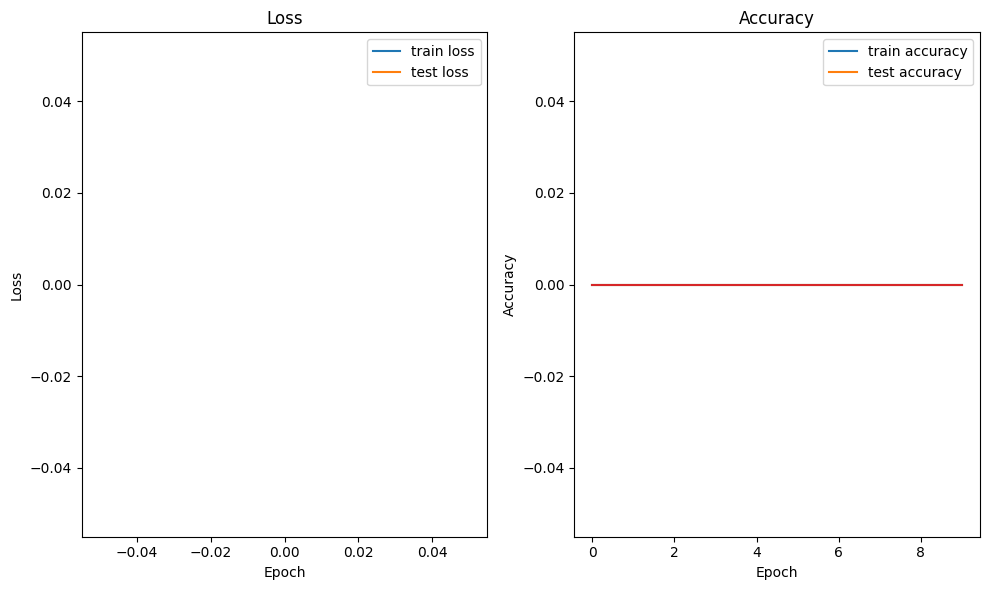

In [ ]:
# Train the best model with all available data
best_model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

# Get the history of the best model
best_model_history = best_model.history.history

# Plot the metrics of the best model
plot_graph_3([best_model_history])

In [ ]:
type(best_model_history)
for key in (best_model_history):
  print('[key]: ', key)



[key]:  loss
[key]:  val_loss
